# Spectra Matrix for Upper Slope 75 kHz ADCP
To create a matrix of 2-month interval, 15-minute resolution spectra for the Upper Slope ADCP.

## Imports

In [3]:
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import numpy as np
import scipy.signal as sig
import scipy.interpolate as interp
import pandas as pd
from scipy.stats import chi2
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib notebook

## Dataset management
First, load complete dataset.

In [4]:
ds = xr.open_dataset('../../Data/SlopeAll/Slope_20120529_20130529.nc')
print(ds.u)

<xarray.DataArray 'u' (time: 35000, depth: 50)>
[1750000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2012-05-29T10:07:30 ... 2013-05-28T23:52:29.999996672
  * depth    (depth) float32 378.5992 370.5992 ... -5.4007993 -13.400799
Attributes:
    standard_name:  eastward_sea_water_velocity
    long_name:      eastward sea water velocity
    units:          meters/second


Then, merge multiple datasets, if necessary (this could probably be its own Notebook, as it should only be done once, in the end).

In [8]:
#ds0 =  xr.open_dataset('../../Data/SlopeAll/Slope_20171021_20181021.nc')     # first dataset
#ds1 =  xr.open_dataset('../../Data/SlopeAll/Slope_20181021_20190516.nc')     # second dataset
#ds = xr.Dataset.merge(ds0,ds1)                                               # merged dataset
#print(ds)                                                                    # check merged dataset is correct

#xr.Dataset.to_netcdf(ds,path='../../Data/SlopeAll/Slope_XXX_XXX.nc')         # save merged desired dataset

## Time
Find specific 2-month time range and format dates. If significant *consecutive* NaN values are present then shorten series for that particular 2-month spectrum. For now this is a single iteration of a 2-month interval, but when done this will be a loop that breaks the entire dataset into 2-month intervals and deals with the data in that interval appropriately, before adding the spectra to the matrix.

Initial time range: 2012-05-29T10:07:30.000000000 2012-12-31T23:37:30.000000000
Time series hits trouble AFTER date: 2012-11-25T12:37:29.999996672
Good data time range: 2012-05-29T10:07:30.000000000 2012-11-25T12:22:30.000000000


/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


<IPython.core.display.Javascript object>


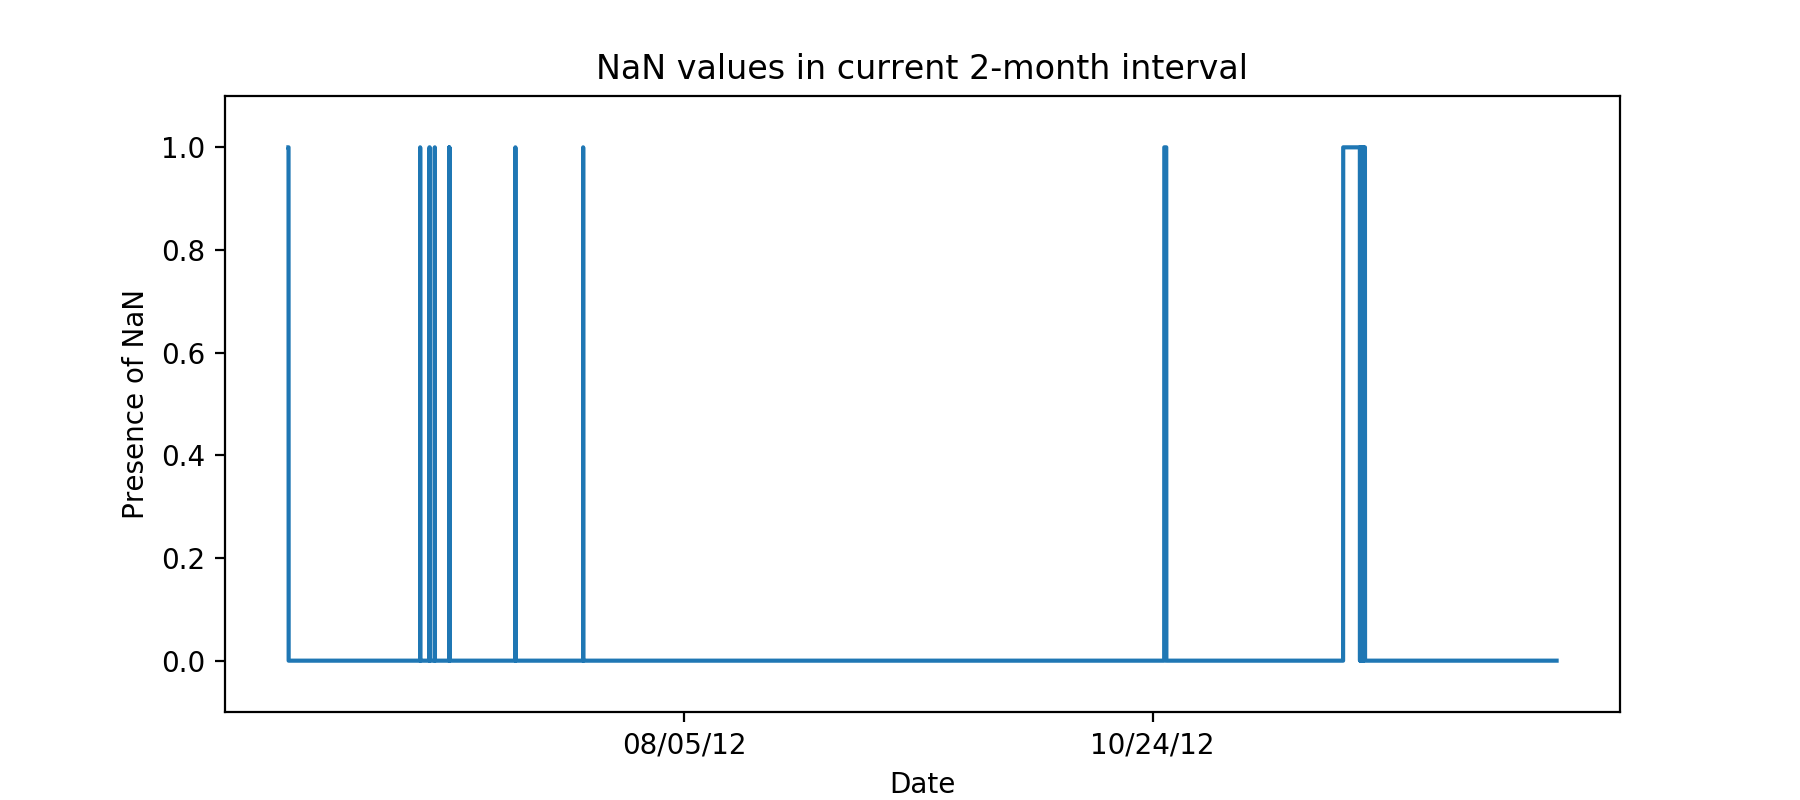

In [5]:
datestimes = pd.to_datetime(ds.time.values)        # convert to datetime from datetime64
datestimes = pd.Series(datestimes)                 # convert to pandas dataframe

start = datestimes[datestimes >= pd.datetime(2012,5,29)].index[0]     # desired start date
end = datestimes[datestimes < pd.datetime(2013,1,1)].index[-1]       # desired end date
time_total = ds.time.values[start:end]                               # total interval
print("Initial time range:",np.min(time_total),np.max(time_total))   # print to check desired interval

# check new time series for significant NaN values
depth_test = int(len(ds.depth)/2)                    # mid-depth for ideal data (less noise, etc.)          
u_test = np.array(ds.u[start:end,depth_test])        # u data at this depth
NaN_series = np.zeros(len(u_test))                   # empty array to indicate NaN values
counter = 0                                          # counter to keep track of # of consecutive NaN values
for i in range(len(time_total)):                     # loop to count consecutive NaN values
    if np.isnan(u_test[i])==True:                    # add to counter if NaN = true
        NaN_series[i] = 1
        counter += 1
        if counter==96:                              # a consecutive day worth of NaN considered significant
            dead = i-96                              # date time series hits significant NaN interval
            print("Time series hits trouble AFTER date:",time_total[dead])
            time_new = time_total[0:dead]            # new truncated interval
            end -= (len(time_total)-len(time_new))   # new end date 
            print("Good data time range:",np.min(time_new),np.max(time_new))
    elif np.isnan(u_test[i])==False:                 # reset counter if NaN inconsistent
        counter = 0          

# usable interval of the 2-month period, for next steps
time = ds.time.values[start:end]                     
        
# plot to show where NaN values exist in the total 2-month interval
fig,ax = plt.subplots(1,1,figsize=(9,4))
ax.plot(time_total,NaN_series)
ax.set_xlabel('Date')
date_form = pldates.DateFormatter("%m/%d/%y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_ylim(-0.1,1.1)
ax.set_ylabel('Presence of NaN')
ax.set_title('NaN values in current 2-month interval')
plt.show()

## Depth

Truncate data to a specific depth interval to eliminate bad data (from visual inspection of velocity plots) from the top and bottom. This could be moved up to Dataset Management, as it can be applied to the complete merged dataset before splitting into 2-month intervals. Will think on this; for now, it's fine here.

In [6]:
# function to find nearby indices for desired depth values
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx     # returns index of nearest depth value

array = ds.depth   # input array to process 
upval = 100        # upper depth for data, metres
lowval = 330       # lower depth for data
upidx = find_nearest(array, upval)               # index of upper depth cutoff
lowidx = find_nearest(array,lowval)              # index of lower depth cutoff 

print("Index at upper depth cutoff:", find_nearest(array, upval))
print("Value at upper depth cutoff:", -ds.depth.values[upidx], "metres" )
print('---')
print("Index at lower depth cutoff:", find_nearest(array, lowval))
print("Value at lower depth cutoff:", -ds.depth.values[lowidx], "metres" )

depth = np.array(ds.depth[lowidx:upidx+1])       # remove unwanted depths, this will be used in the next steps

print('---')
print("Length of new depth array: ", len(depth)) # new depth interval
print('Upper limit at',-depth[-1],'metres')      # depth for upper PSD
print('Lower limit at',-depth[0],'metres')       # depth for lower PSD

Index at upper depth cutoff: 35
Value at upper depth cutoff: -98.5992 metres
---
Index at lower depth cutoff: 6
Value at lower depth cutoff: -330.5992 metres
---
Length of new depth array:  30
Upper limit at -98.5992 metres
Lower limit at -330.5992 metres


## Rotate, interpolate data
Loop to acquire rotated and NaN filtered data.

Data rotated based on a visual estimate of along-slope angle, as 30$^{\circ}$. This could be updated to reflect Thomson's work at the A1 site, relatively nearby.

Data are also interpolated to deal with minor instances of NaN values. Consistent NaN intervals are dealt with in the Time section, above.

In [11]:
# rotate data
theta_along_slope = np.radians(30)                       # rotation angle in radians, 30 degrees
u_vec = ds.u[start:end,lowidx:upidx+1] + 1j*ds.v[start:end,lowidx:upidx+1]  # vector form of horizontal velocity
u_vec_new = u_vec*np.exp(-1j*theta_along_slope)          # rotated velocity vector
u_rot = np.real(u_vec_new)                               # u_new = Re(rotated vector)
v_rot = np.imag(u_vec_new)                               # v_new = Im(rotated vector)
w_new = ds.w[start:end,lowidx:upidx+1]                   # w based on time and depth filters

# filter NaN instances from data
t = len(time)                  # number of time data points after checking for consistent NaN intervals
d = len(depth)                 # number of depth data points after removing unwanted depths

uorig = np.empty([t,d])        # empty array for rotated u data
vorig = np.empty([t,d])        # empty array for rotated v data
worig = np.empty([t,d])        # empty array for rotated w data
vlp = np.empty([t,d])          # empty array for low-pass filtered v values

for j in range(d):                       # loop to filter NaN instances from all depths
    utemp = pd.Series(u_rot[:,j])
    uint = utemp.interpolate(method="cubic")
    uorig[:,j] = uint                    # set interpolated data to original array
    
    vtemp = pd.Series(v_rot[:,j])
    vint = vtemp.interpolate(method="cubic")
    vorig[:,j] = vint                    # set interpolated data to original array
    vlp[:,j] = sig.filtfilt(b, a, vint)  # set low pass array values
    
    wtemp = pd.Series(w_new[:,j])
    wint = wtemp.interpolate(method="cubic")
    worig[:,j] = wint                    # set interpolated data to original array

## Welch FFT

Remove the mean from upper and lower depth limits, for spectra at those depths.

Also obtain depth mean data for an average spectra through depth.

Perform Welch FFT with adjustable parameters, using a Parzen window and what seems to be an optimal averaging process, based on visual analysis of spectral output.

Calculate 95% confidence intervals using a chi$^2$ based method.

In [62]:
# remove mean from upper and lower depth limits

# lower depth limit
umlow = uorig[:,0] - np.mean(uorig[:,0]) 
vmlow = vorig[:,0] - np.mean(vorig[:,0])
wmlow = worig[:,0] - np.mean(worig[:,0])

# upper depth limit
umup = uorig[:,-1] - np.mean(uorig[:,-1]) 
vmup = vorig[:,-1] - np.mean(vorig[:,-1])
wmup = worig[:,-1] - np.mean(worig[:,-1])

In [63]:
# depth mean data

um_depth = np.zeros(t)  
vm_depth = np.zeros(t)
wm_depth = np.zeros(t)

for i in range(t):
    um_depth[i] = np.mean(uorig[i,:])
for i in range(t):
    vm_depth[i] = np.mean(vorig[i,:])
for i in range(t):
    wm_depth[i] = np.mean(worig[i,:])
    
um_depth -= np.mean(uorig)
vm_depth -= np.mean(vorig)
wm_depth -= np.mean(worig)

In [64]:
# Welch FFT
fs_x = 4
window_x = 'parzen'
np_len = int(len(time)/25)   # find optimal average for nperseg
nperseg_x = np_len        

# lower depth
umlow_f, umlow_PSD = sig.welch(umlow, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vmlow_f, vmlow_PSD = sig.welch(vmlow, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
wmlow_f, wmlow_PSD = sig.welch(wmlow, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

# upper depth
umup_f, umup_PSD = sig.welch(umup, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vmup_f, vmup_PSD = sig.welch(vmup, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
wmup_f, wmup_PSD = sig.welch(wmup, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

# depth mean
um_depth_f, um_depth_PSD = sig.welch(um_depth, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vm_depth_f, vm_depth_PSD = sig.welch(vm_depth, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
wm_depth_f, wm_depth_PSD = sig.welch(wm_depth, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

In [65]:
# error bars (95% confidence intervals)

probability = 0.95                            # calculate confidence intervals
alpha = 1 - probability        
NS = len(time) / (nperseg_x / 2)              # number of estimates, Welch
vp = (4/3)*NS                                 # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                                  # interval coefficients

umlow_lower = umlow_PSD * cint[0]             # define upper and lower confidence values
umlow_upper = umlow_PSD * cint[1]
vmlow_lower = vmlow_PSD * cint[0]             # define upper and lower confidence values
vmlow_upper = vmlow_PSD * cint[1]
wmlow_lower = wmlow_PSD * cint[0]             # define upper and lower confidence values
wmlow_upper = wmlow_PSD * cint[1]

umup_lower = umup_PSD * cint[0]           # define upper and lower confidence values
umup_upper = umup_PSD * cint[1]
vmup_lower = vmup_PSD * cint[0]           # define upper and lower confidence values
vmup_upper = vmup_PSD * cint[1]
wmup_lower = wmup_PSD * cint[0]           # define upper and lower confidence values
wmup_upper = wmup_PSD * cint[1]

## Save spectra***

Currently reworking this section.

Saves current 2-month spectra to file, to then be compiled into a single dataset. In the end this should be saving the current spectra to a row or column in the matrix, as part of the processing loop.

# Plots

To check effectiveness of output spectra. To be implemented in the loop? Ask Jody.

## Spectra

### Comparitive Spectra

<IPython.core.display.Javascript object>


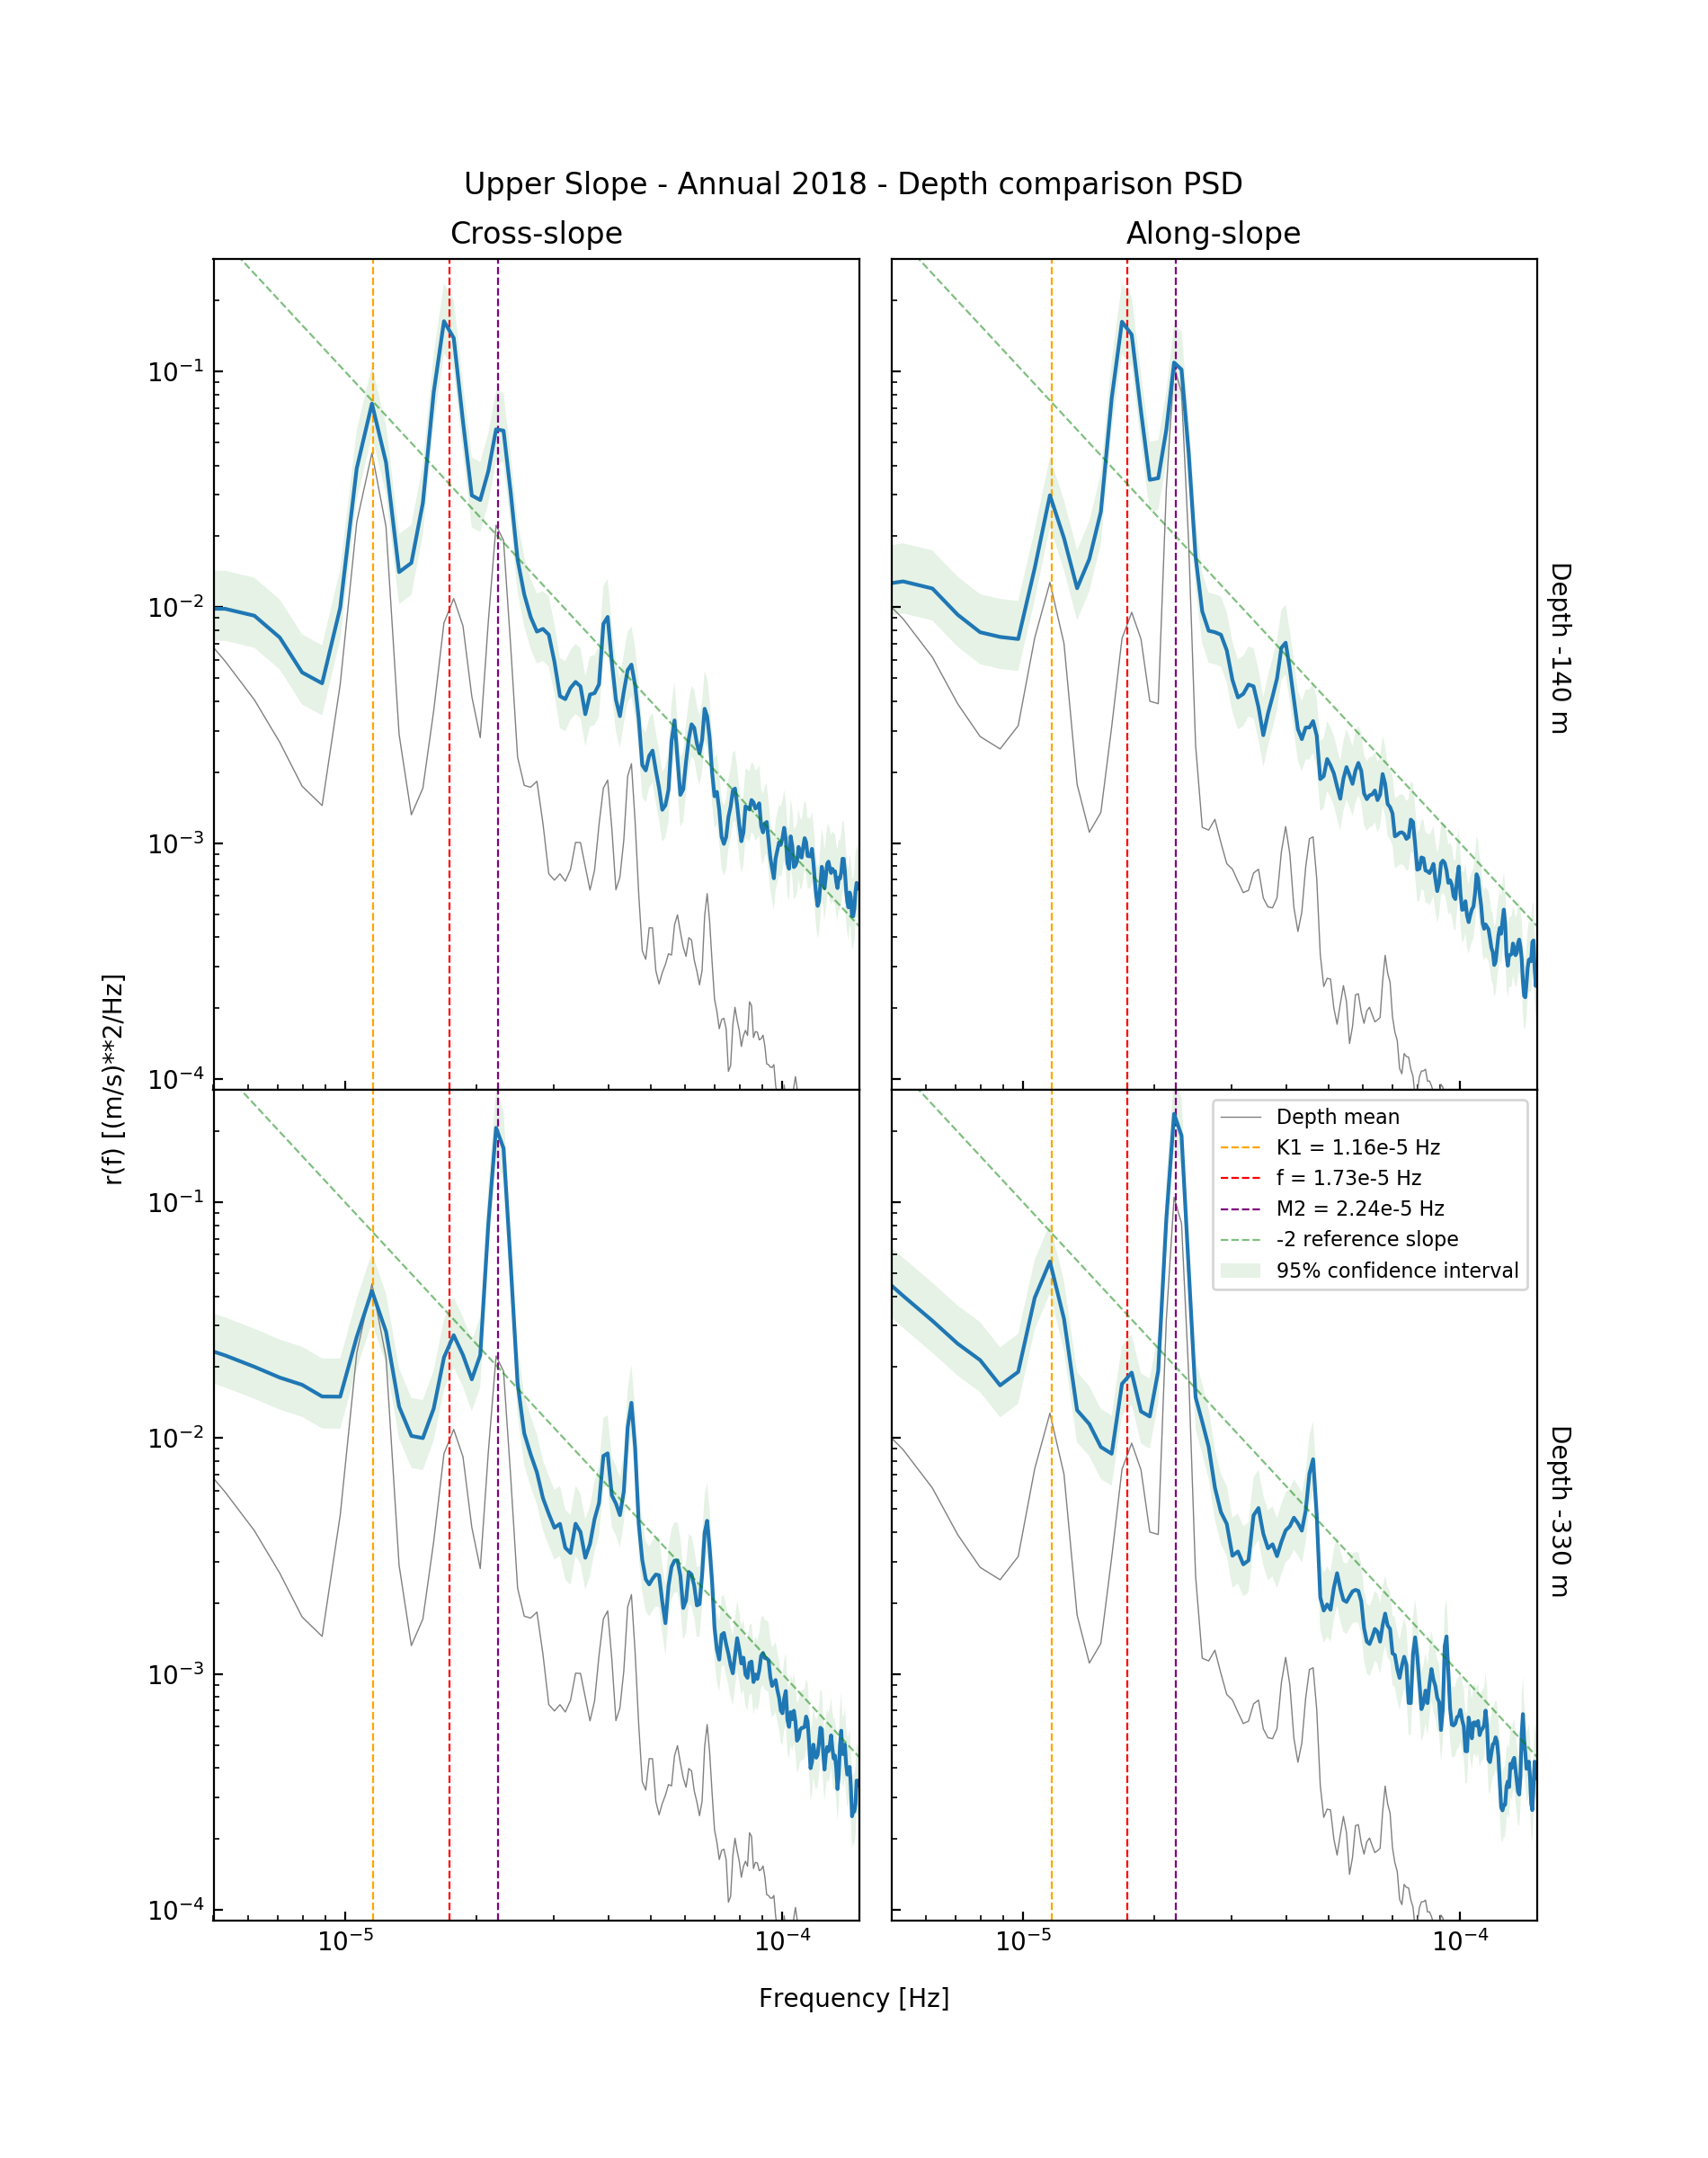

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in power


In [360]:
fig, axs = plt.subplots(2,2,figsize=(9.5,12), sharex=True, sharey=True)
(ax1,ax2),(ax3,ax4) = axs
fig.subplots_adjust(hspace=0, wspace=0.05)

ax1.loglog(um_depth_f/3600,um_depth_PSD,color='gray',lw=0.5)
ax2.loglog(vm_depth_f/3600,vm_depth_PSD,color='gray',lw=0.5)
ax3.loglog(um_depth_f/3600,um_depth_PSD,color='gray',lw=0.5)
ax4.loglog(vm_depth_f/3600,vm_depth_PSD,color='gray',lw=0.5,label='Depth mean')

ax1.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax1.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax1.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax1.loglog(umup_f/3600, umup_PSD)
ax1.tick_params(axis='both', direction='in', which='both')
ax1.set_ylim(9e-5,3e-1)
ax1.set_xlim(5e-6,1.5e-4)
ax1.set_title('Cross-slope')

ax2.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax2.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax2.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax2.tick_params(axis='both', direction='in', which='both')
ax2.loglog(vmup_f/3600, vmup_PSD)
ax2.set_title('Along-slope')

ax3.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax3.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax3.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax3.tick_params(axis='both', direction='in', which='both')
ax3.loglog(umlow_f/3600, umlow_PSD)

ax4.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax4.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax4.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax4.tick_params(axis='both', direction='in', which='both')
ax4.loglog(vmlow_f/3600, vmlow_PSD)

fig.text(0.905, 0.7, 'Depth -140 m', va='center',rotation='270')
fig.text(0.905, 0.3, 'Depth -330 m', va='center',rotation='270')
fig.text(0.5,0.91,'Upper Slope - Annual 2018 - Depth comparison PSD', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'r(f) [(m/s)**2/Hz]', va='center', rotation='vertical')
fig.text(0.5,0.07,'Frequency [Hz]',ha='center')

ax1.fill_between(umup_f/3600, umup_lower, umup_upper, facecolor='green', alpha=0.1)
ax2.fill_between(vmup_f/3600, vmup_lower, vmup_upper, facecolor='green', alpha=0.1)
ax3.fill_between(umlow_f/3600, umlow_lower, umlow_upper, facecolor='green', alpha=0.1)
ax4.fill_between(vmlow_f/3600, vmlow_lower, vmlow_upper, facecolor='green', alpha=0.1, label='95% confidence interval')

ax1.loglog(umlow_f/3600,(10e-12)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax2.loglog(umlow_f/3600,(10e-12)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax3.loglog(umlow_f/3600,(10e-12)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax4.loglog(umlow_f/3600,(10e-12)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5, label='-2 reference slope')

plt.legend(loc='upper right', fontsize=8)
plt.show()

<IPython.core.display.Javascript object>


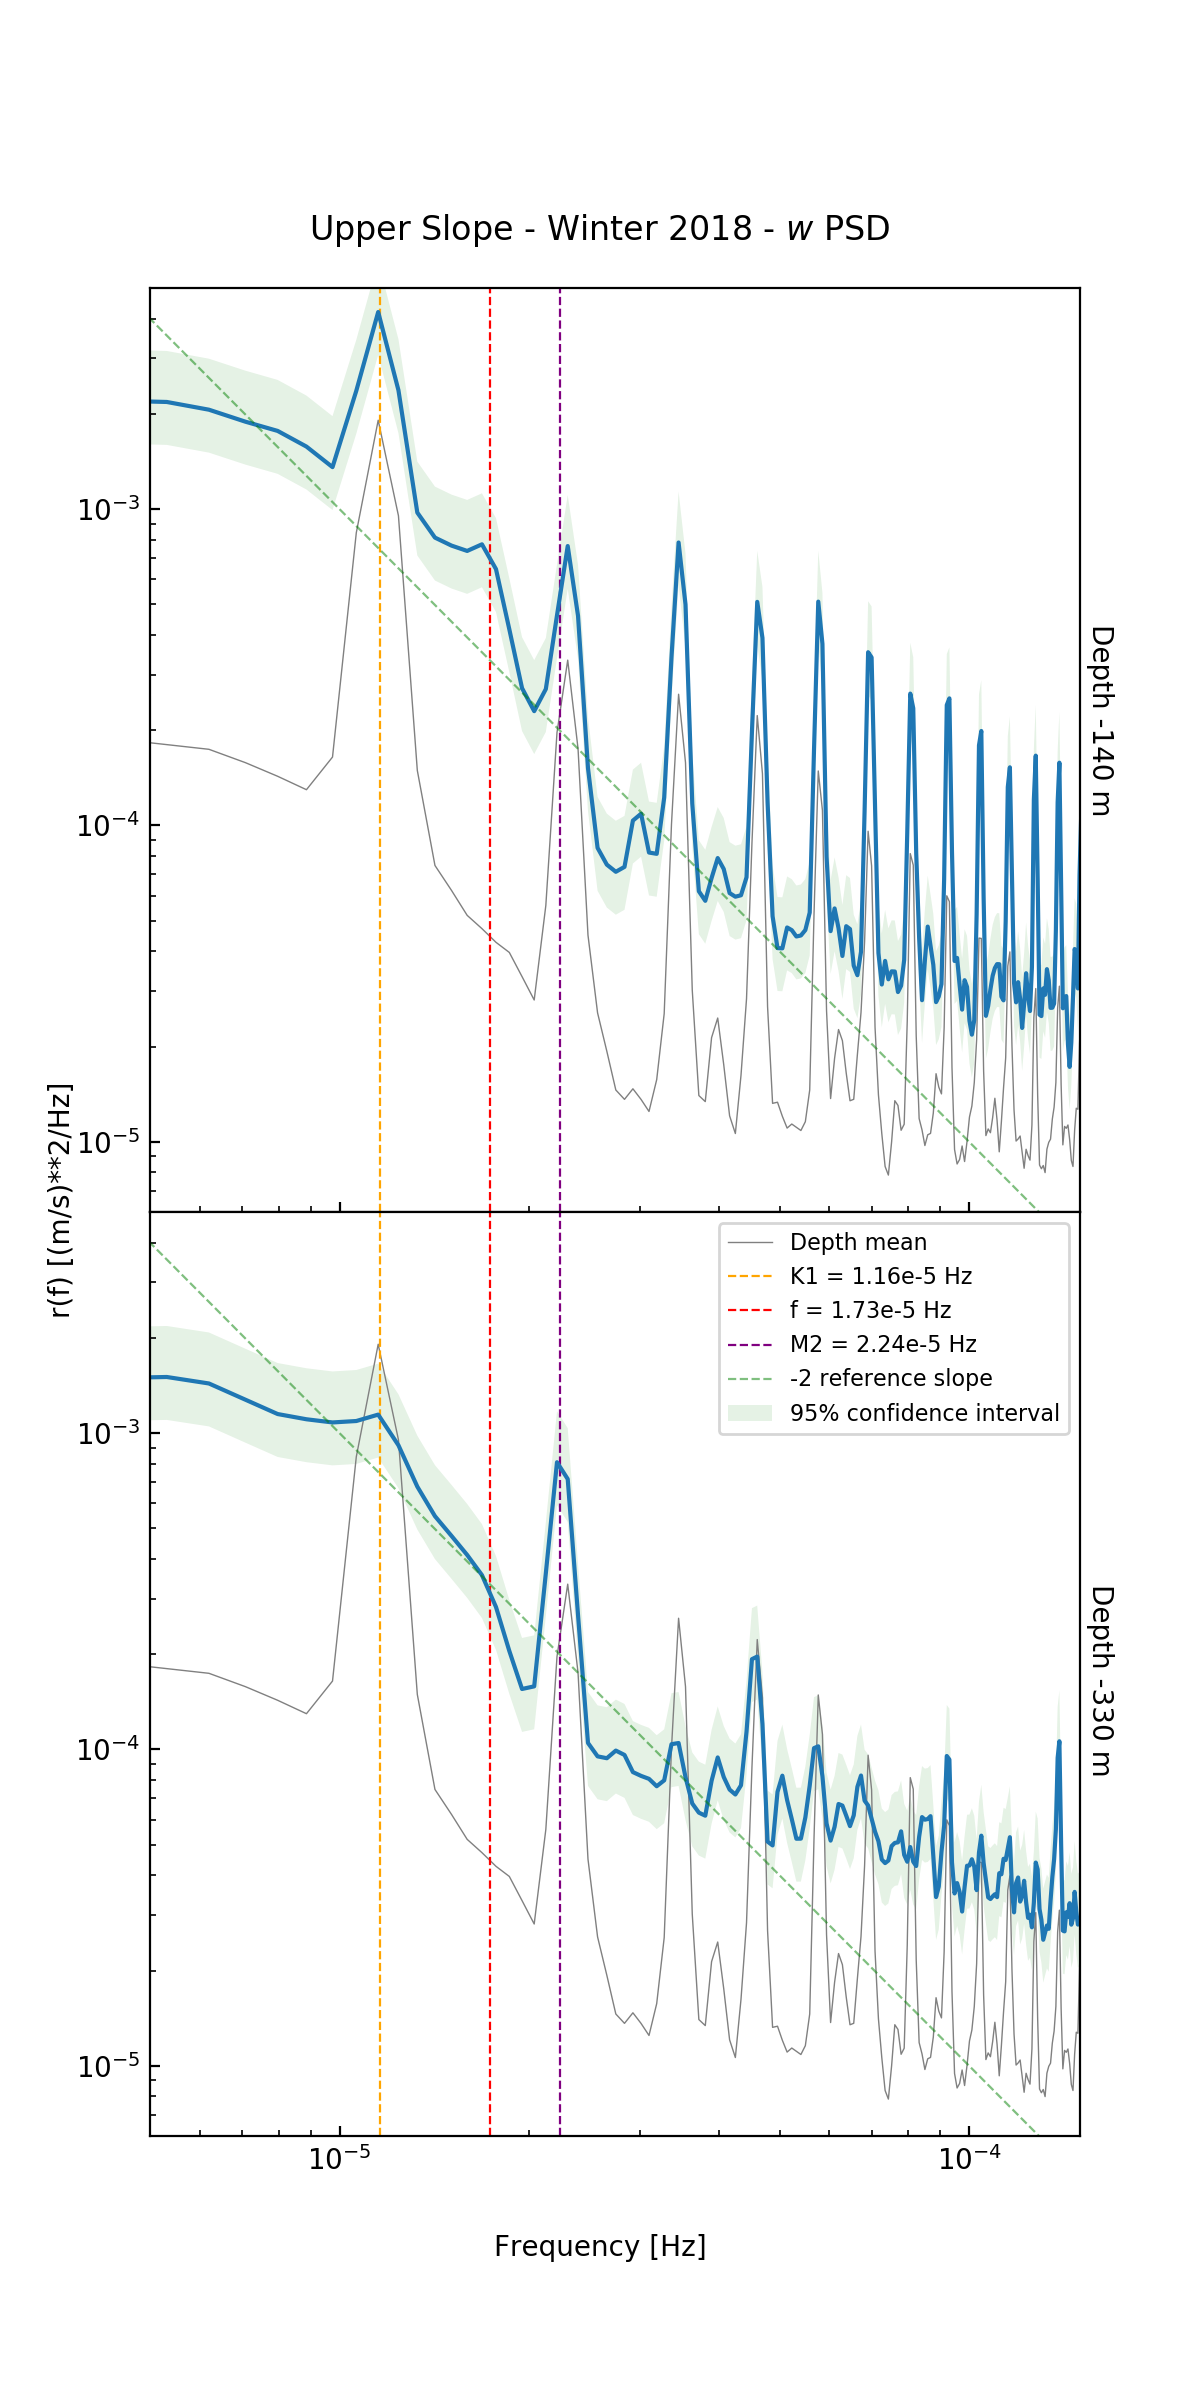

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in power


In [361]:
fig, axs = plt.subplots(2,1,figsize=(6,12), sharex=True, sharey=True)
(ax1,ax2) = axs
fig.subplots_adjust(hspace=0, wspace=0)

ax1.loglog(wm_depth_f/3600,wm_depth_PSD,color='gray',lw=0.5)
ax2.loglog(wm_depth_f/3600,wm_depth_PSD,color='gray',lw=0.5,label='Depth mean')

ax1.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax1.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax1.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax1.tick_params(axis='both', direction='in', which='both')
ax1.loglog(wmup_f/3600, wmup_PSD)
ax1.set_ylim(6e-6,5e-3)
ax1.set_xlim(5e-6,1.5e-4)

ax2.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax2.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax2.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax2.tick_params(axis='both', direction='in', which='both')
ax2.loglog(wmlow_f/3600, wmlow_PSD)

fig.text(0.905, 0.7, 'Depth -140 m', va='center',rotation='270')
fig.text(0.905, 0.3, 'Depth -330 m', va='center',rotation='270')
fig.text(0.5,0.90,'Upper Slope - Winter 2018 - $w$ PSD', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'r(f) [(m/s)**2/Hz]', va='center', rotation='vertical')
fig.text(0.5,0.06,'Frequency [Hz]',ha='center')

ax1.fill_between(wmup_f/3600, wmup_lower, wmup_upper, facecolor='green', alpha=0.1)
ax2.fill_between(wmlow_f/3600, wmlow_lower, wmlow_upper, facecolor='green', alpha=0.1, label='95% confidence interval')

ax1.loglog(umlow_f/3600,(10e-14)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax2.loglog(umlow_f/3600,(10e-14)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5,label='-2 reference slope')

plt.legend(loc='upper right', fontsize=8)
plt.show()

### Depth = -330 meters

<IPython.core.display.Javascript object>


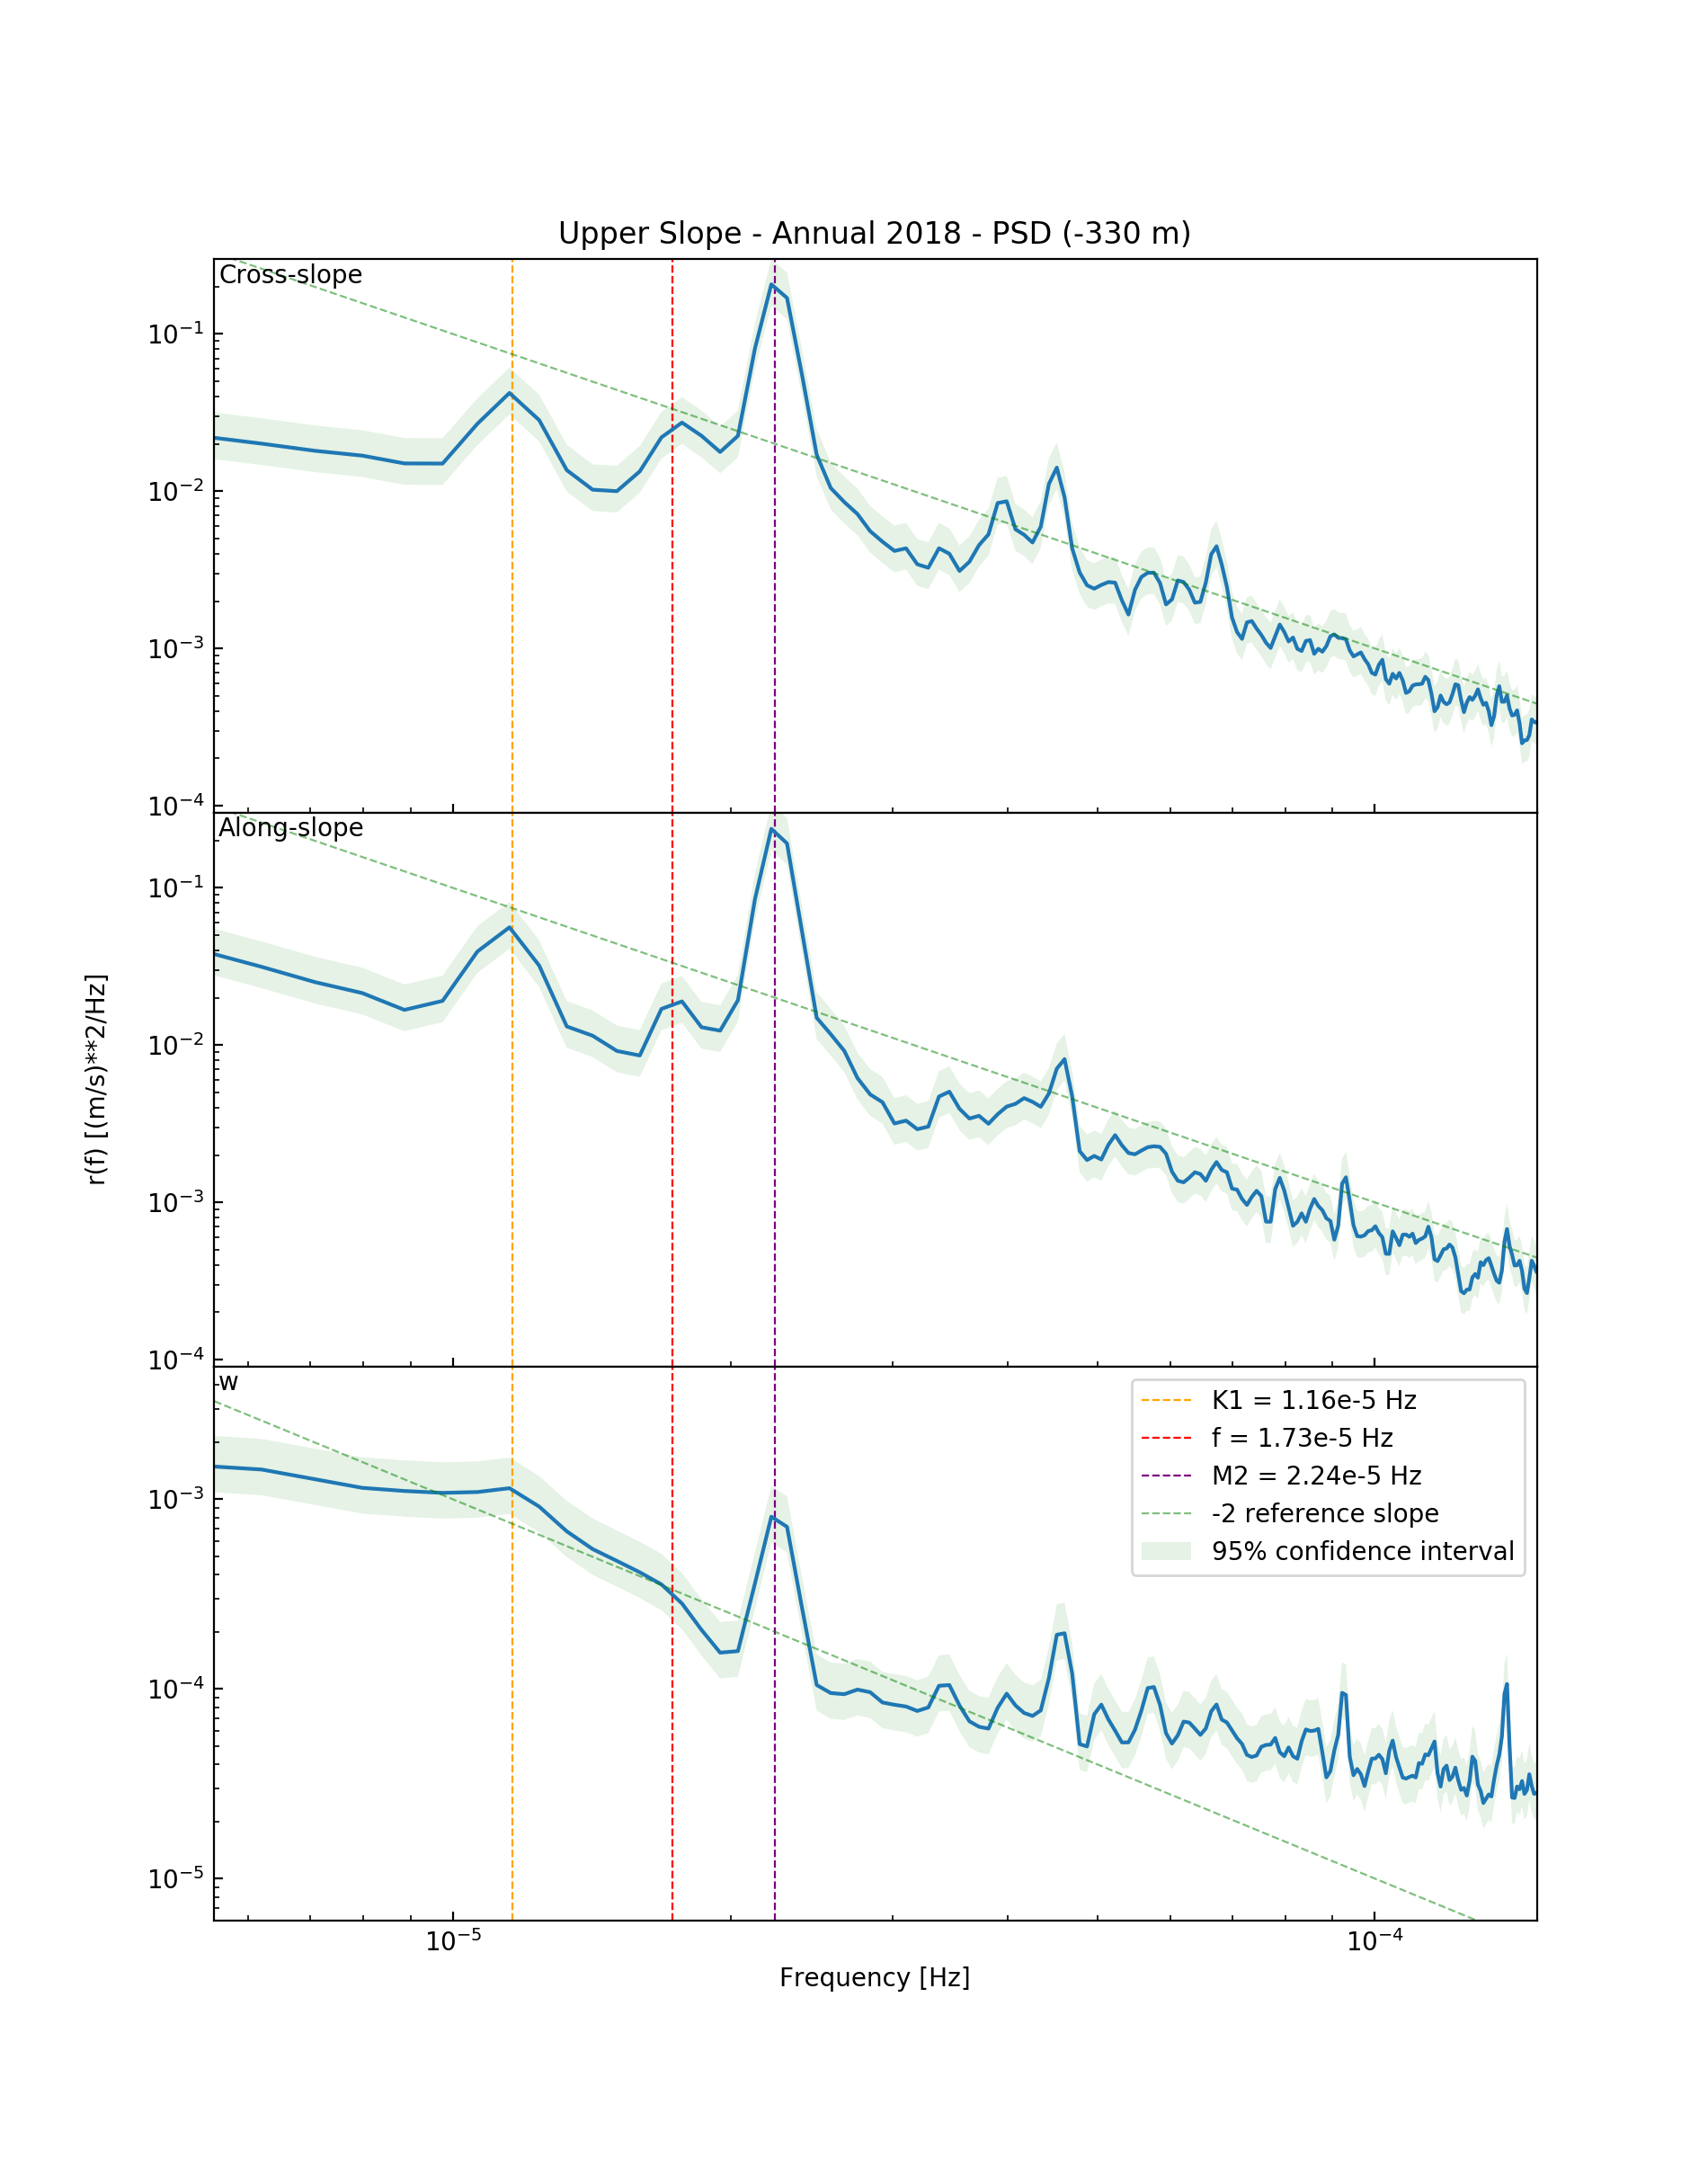

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in power


In [358]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9.5,12), sharex=True)
fig.subplots_adjust(hspace = 0.0)

ax1.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz") # inertial period
ax1.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax1.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax1.loglog(umlow_f/3600, umlow_PSD)
ax1.set_ylim(9e-5,3e-1)
ax1.set_xlim(5.5e-6,1.5e-4)
ax1.set_title('Upper Slope - Annual 2018 - PSD (-330 m)')
ax1.tick_params(axis='both', direction='in', which='both')
ax1.fill_between(umlow_f/3600, umlow_lower, umlow_upper, facecolor='green', alpha=0.1)

ax2.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz") # inertial period
ax2.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax2.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax2.loglog(vmlow_f/3600, vmlow_PSD)
ax2.set_ylim(9e-5,3e-1)
ax2.tick_params(axis='both', direction='in', which='both')
ax2.fill_between(vmlow_f/3600, vmlow_lower, vmlow_upper, facecolor='green', alpha=0.1)

ax3.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz") # inertial period
ax3.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax3.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax3.loglog(wmlow_f/3600, wmlow_PSD)
ax3.set_ylim(6e-6,5e-3)
ax3.set_xlabel('Frequency [Hz]')
ax3.tick_params(axis='both', direction='in', which='both')
ax3.fill_between(wmlow_f/3600, wmlow_lower, wmlow_upper, facecolor='green', alpha=0.1, label='95% confidence interval')

ax1.loglog(umlow_f/3600,(10e-12)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax2.loglog(umlow_f/3600,(10e-12)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax3.loglog(umlow_f/3600,(10e-14)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5, label='-2 reference slope')

fig.text(0.05, 0.5, 'r(f) [(m/s)**2/Hz]', va='center', rotation='vertical')
fig.text(0.128, 0.872, 'Cross-slope', va='center')
fig.text(0.128, 0.616, 'Along-slope', va='center')
fig.text(0.128, 0.359, 'w', va='center')

plt.legend(loc='upper right')
plt.show()

### Depth = -140 meters

<IPython.core.display.Javascript object>


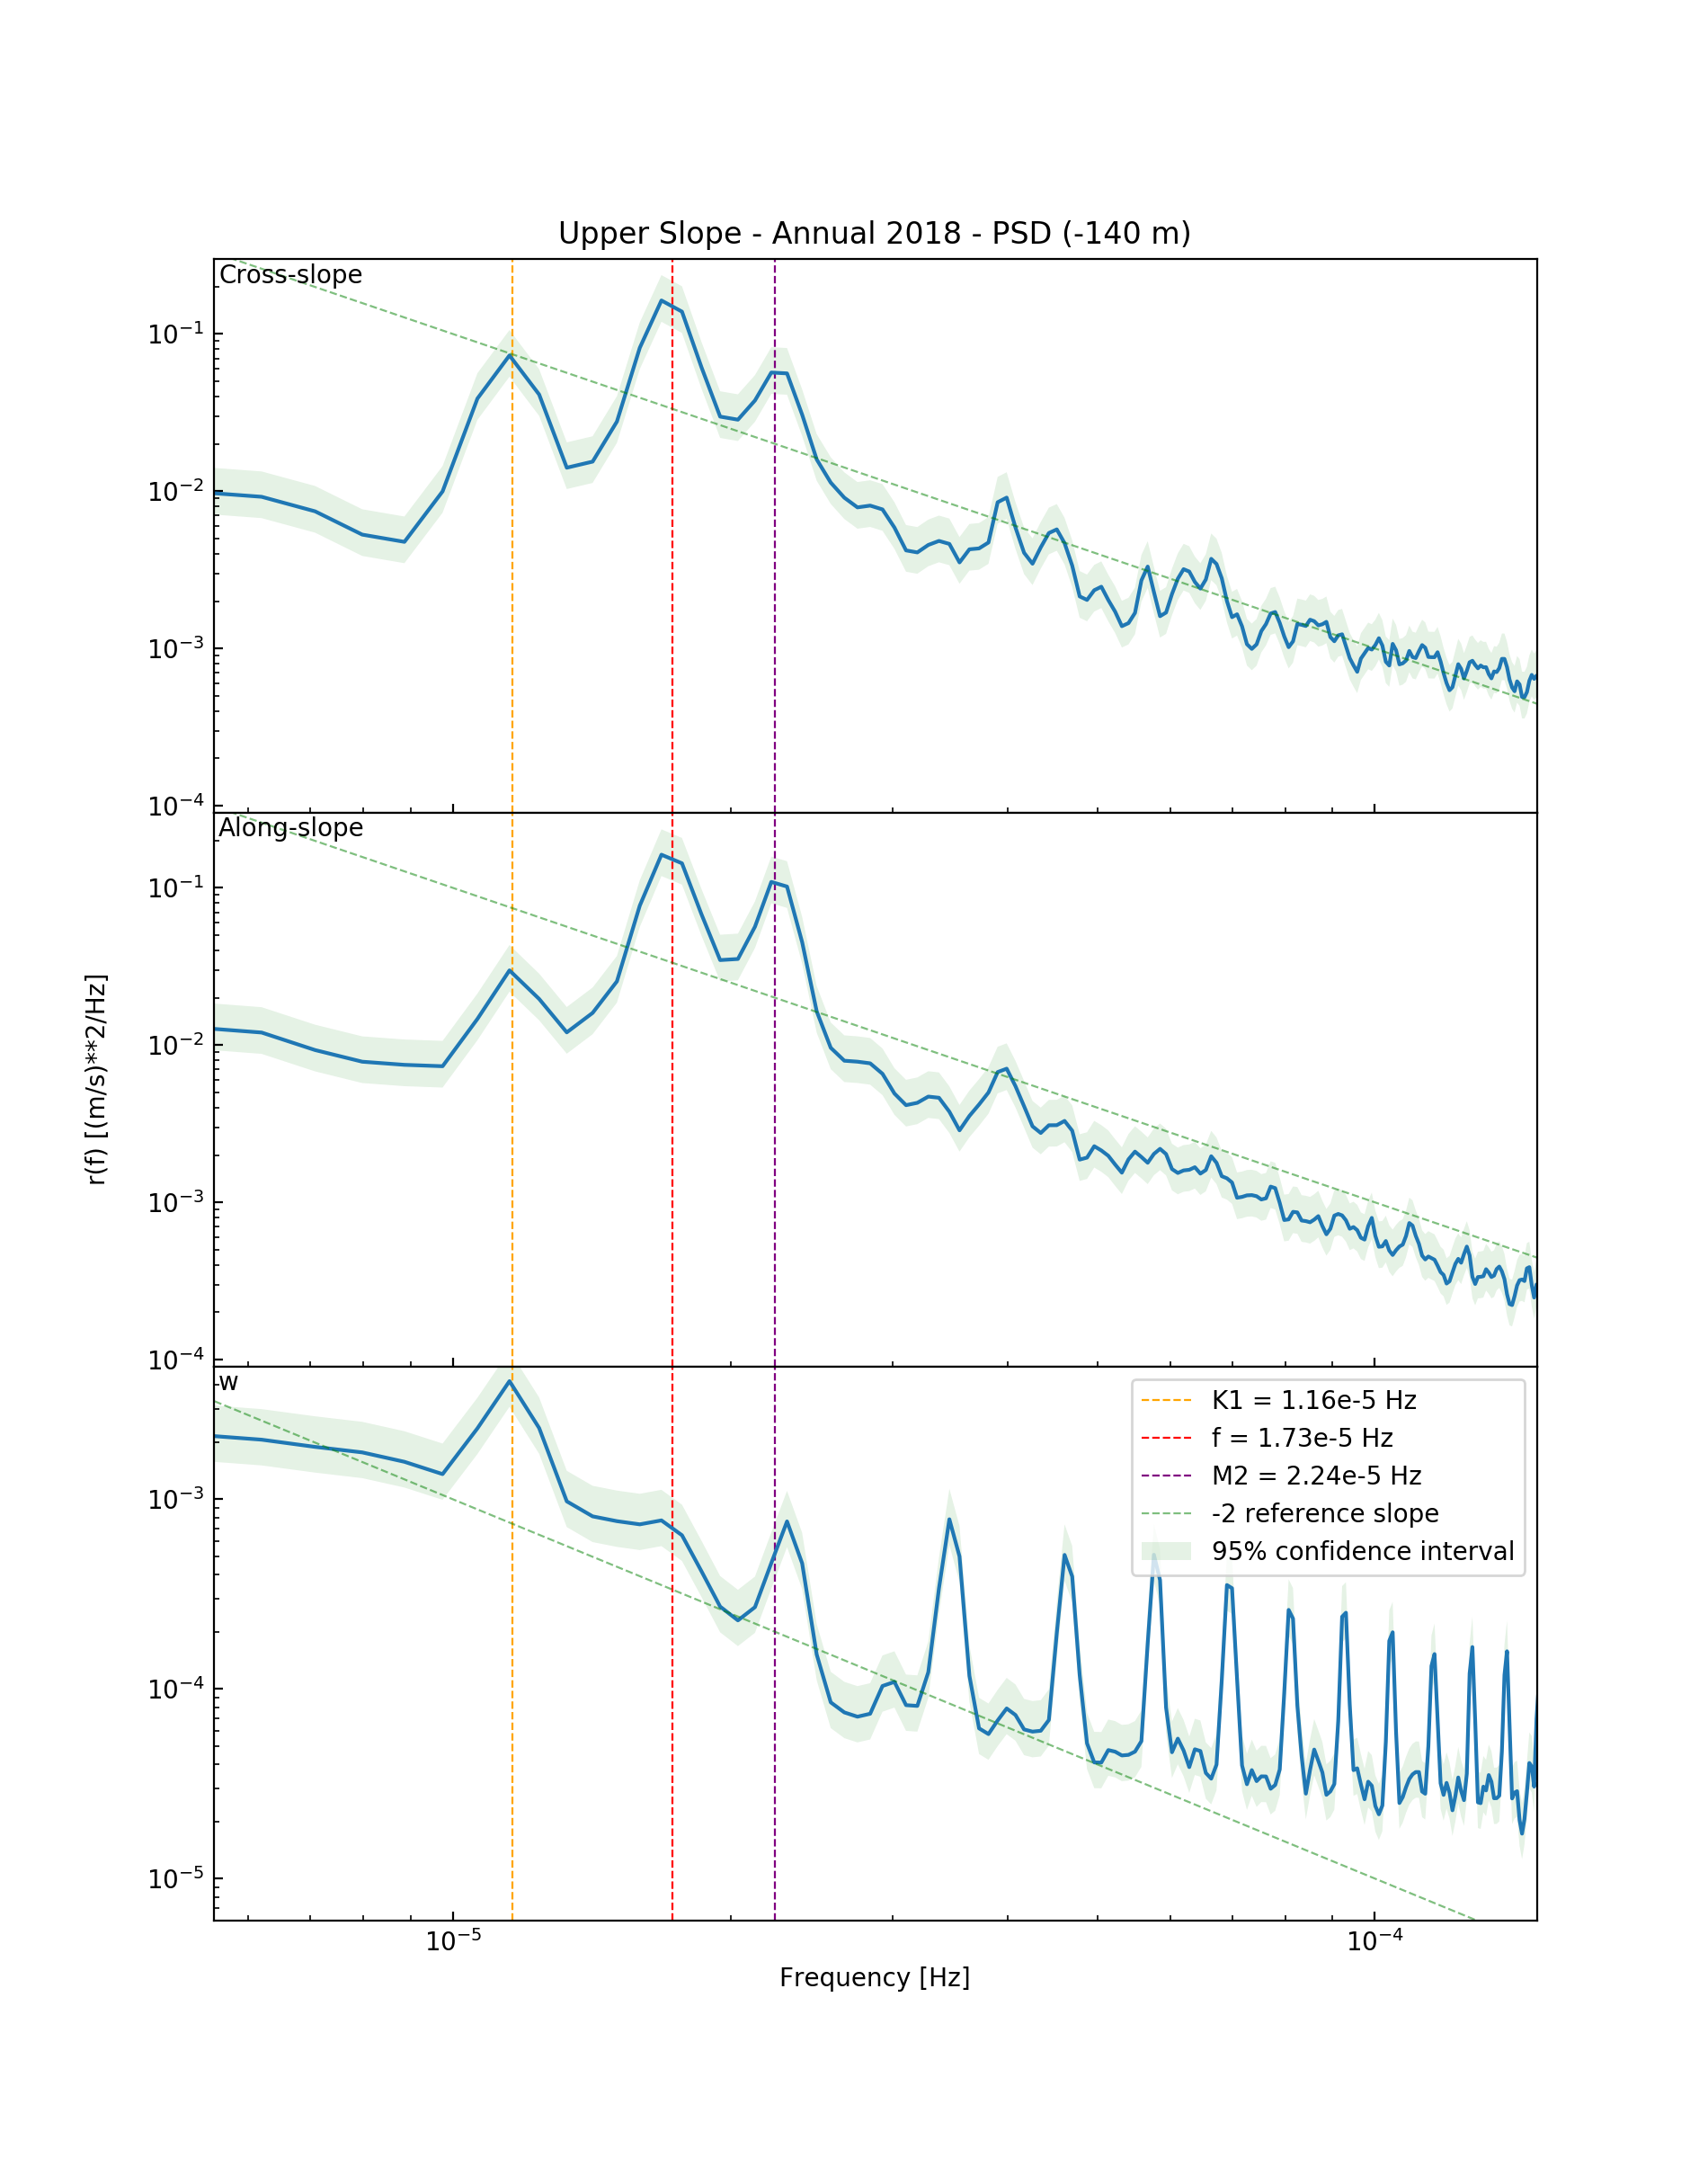

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in power


In [359]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9.5,12), sharex=True)
fig.subplots_adjust(hspace = 0.0)

ax1.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax1.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax1.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax1.loglog(umup_f/3600, umup_PSD)
ax1.set_ylim(9e-5,3e-1)
ax1.set_xlim(5.5e-6,1.5e-4)
ax1.tick_params(axis='both', direction='in', which='both')
ax1.set_title('Upper Slope - Annual 2018 - PSD (-140 m)')

ax2.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax2.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax2.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax2.loglog(vmup_f/3600, vmup_PSD)
ax2.set_ylim(9e-5,3e-1)
ax2.tick_params(axis='both', direction='in', which='both')

ax3.axvline(1.161e-5, color ='orange',ls='--',lw=0.8,label = "K1 = 1.16e-5 Hz")
ax3.axvline(1.732e-5, color ='red',ls='--', lw=0.8,label = "f = 1.73e-5 Hz")
ax3.axvline(2.236e-5, color ='purple',ls='--',lw=0.8,label = "M2 = 2.24e-5 Hz")
ax3.loglog(wmup_f/3600, wmup_PSD)
ax3.set_ylim(6e-6,5e-3)
ax3.set_xlabel('Frequency [Hz]')
ax3.tick_params(axis='both', direction='in', which='both')

ax1.fill_between(umup_f/3600, umup_lower, umup_upper, facecolor='green', alpha=0.1)
ax2.fill_between(vmup_f/3600, vmup_lower, vmup_upper, facecolor='green', alpha=0.1)
ax3.fill_between(wmup_f/3600, wmup_lower, wmup_upper, facecolor='green', alpha=0.1, label='95% confidence interval')

ax1.loglog(umup_f/3600,(10e-12)*(umup_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax2.loglog(umup_f/3600,(10e-12)*(umup_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax3.loglog(umup_f/3600,(10e-14)*(umup_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5, label='-2 reference slope')

fig.text(0.05, 0.5, 'r(f) [(m/s)**2/Hz]', va='center', rotation='vertical')
fig.text(0.128, 0.872, 'Cross-slope', va='center')
fig.text(0.128, 0.616, 'Along-slope', va='center')
fig.text(0.128, 0.359, 'w', va='center')

plt.legend(loc='upper right')
plt.show()

## Velocity

In [8]:
# low pass Butterworth filter for 40 hour cut-off to remove 30 hour tides

fs = 4                # 4 samples per HOUR for entire time series
fc = 0.025            # 40 hour low pass filter cut-off
Wn = fc / (fs / 2)    # normalised cut-off frequencies
b, a = sig.butter(8, Wn,'lowpass')  # digital butterworth filter
w, h = sig.freqz(b, a)

In [9]:
vlp = np.empty([t,d])          # empty array for low-pass filtered v values
for j in range(d):             # loop to filter tides from all depths                
    vlp[:,j] = sig.filtfilt(b, a, vint)  # set low pass array values

<IPython.core.display.Javascript object>


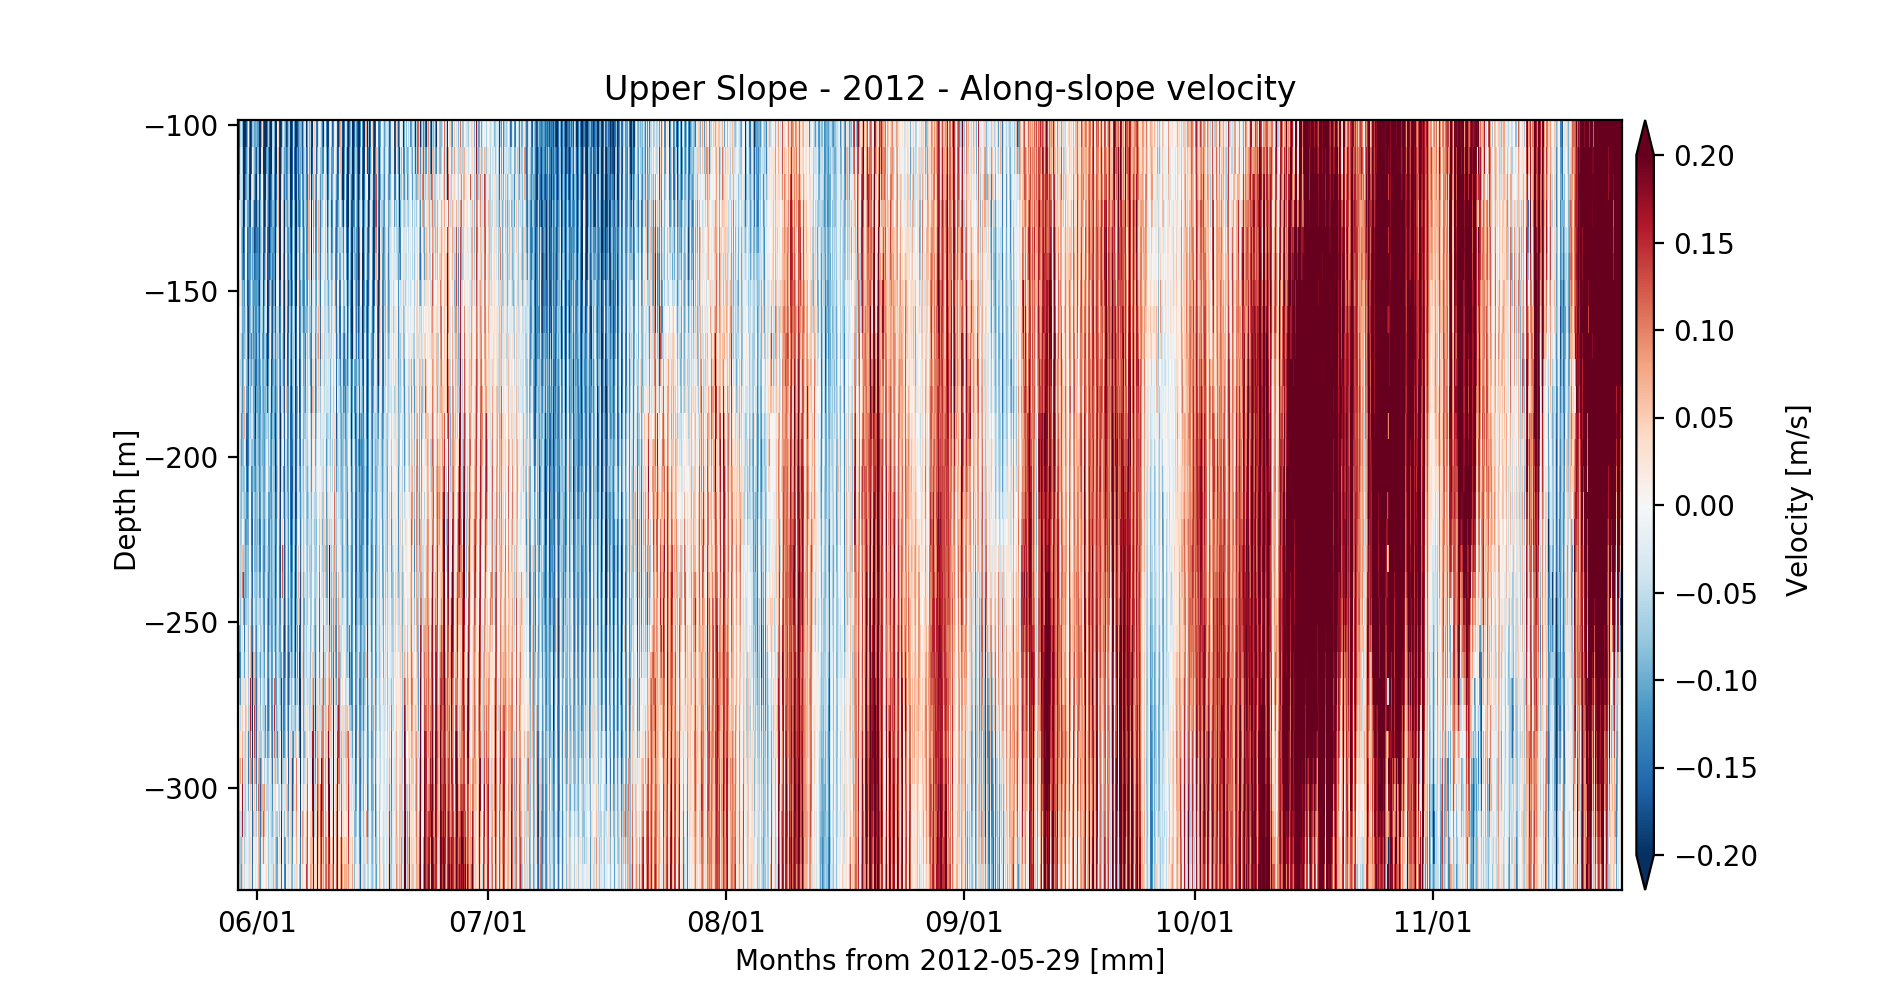

In [14]:
# plot along-slope data

fig, ax = plt.subplots(1, 1, figsize=(9.5,5))
fig.text(0.5, 0.9, 'Upper Slope - 2012 - Along-slope velocity', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.03, f'Months from {datestimes.dt.date[start]} [mm]', ha='center')

im1 = ax.pcolormesh(time, -depth, vorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar1 = fig.colorbar(im1, ax=ax, fraction=0.05, pad=0.01, aspect=40, extend='both')

date_form = pldates.DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)